In [ ]:
# Notebook: 03_cushion_data_prep.ipynb

import pandas as pd
import numpy as np
import glob
from pathlib import Path

# ============================================
# STEP 1: Load and combine input data (frame 1 only)
# ============================================

print("Loading input files...")
input_dfs = []

for week in range(1, 19):
    file_path = f'../data/train/input_2023_w{week:02d}.csv'
    
    # Read only frame 1 to save memory
    df = pd.read_csv(file_path)
    df_frame1 = df[df['frame_id'] == 1].copy()
    
    # Keep essential columns
    cols_to_keep = [
        'game_id', 'play_id', 'nfl_id', 'frame_id',
        'player_position', 'player_role', 'player_side',
        'ball_land_x', 'ball_land_y'
    ]
    
    df_frame1 = df_frame1[cols_to_keep]
    input_dfs.append(df_frame1)
    
    print(f"  Week {week:02d}: {len(df_frame1)} player-plays")

input_data = pd.concat(input_dfs, ignore_index=True)
print(f"\nTotal input rows (frame 1 only): {len(input_data):,}")

# ============================================
# STEP 2: Load and combine output data (frame 1 only)
# ============================================

print("\nLoading output files...")
output_dfs = []

for week in range(1, 19):
    file_path = f'../data/train/output_2023_w{week:02d}.csv'
    
    df = pd.read_csv(file_path)
    df_frame1 = df[df['frame_id'] == 1].copy()
    
    output_dfs.append(df_frame1)
    print(f"  Week {week:02d}: {len(df_frame1)} player-plays")

output_data = pd.concat(output_dfs, ignore_index=True)
print(f"\nTotal output rows (frame 1 only): {len(output_data):,}")

# ============================================
# STEP 3: Load supplementary data
# ============================================

print("\nLoading supplementary data...")
supp_data = pd.read_csv('../data/supplementary_data.csv')
print(f"Supplementary rows: {len(supp_data):,}")

# ============================================
# STEP 4: Join everything together
# ============================================

print("\nJoining data...")

# Join output with input to get player metadata
combined = output_data.merge(
    input_data,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    how='left'
)

print(f"After joining input+output: {len(combined):,} rows")

# Join with supplementary data to get play context
combined = combined.merge(
    supp_data,
    on=['game_id', 'play_id'],
    how='left'
)

print(f"After joining supplementary: {len(combined):,} rows")

# ============================================
# STEP 5: Filter to relevant plays
# ============================================

print("\nFiltering to analysis dataset...")

# Keep only cornerbacks and wide receivers
combined = combined[
    combined['player_position'].isin(['CB', 'WR'])
].copy()
print(f"After position filter (CB/WR only): {len(combined):,}")

# Keep only man coverage plays
combined = combined[
    combined['team_coverage_man_zone'] == 'MAN_COVERAGE'
].copy()
print(f"After man coverage filter: {len(combined):,}")

# Keep only completions (clean ball_land data)
combined = combined[
    combined['pass_result'] == 'C'
].copy()
print(f"After completions filter: {len(combined):,}")

# Remove plays with null routes
combined = combined[
    combined['route_of_targeted_receiver'].notna()
].copy()
print(f"After route filter: {len(combined):,}")

# ============================================
# STEP 6: Calculate cushion metrics
# ============================================

print("\nCalculating cushion metrics...")

# For each play, we need to pair CBs with WRs
# Strategy: For each WR, find the closest CB

def calculate_cushion_for_play(play_df):
    """
    For a single play, calculate CB-WR cushion
    """
    wrs = play_df[play_df['player_position'] == 'WR']
    cbs = play_df[play_df['player_position'] == 'CB']
    
    if len(wrs) == 0 or len(cbs) == 0:
        return None
    
    results = []
    
    for _, wr in wrs.iterrows():
        # Calculate distance to each CB
        distances = []
        for _, cb in cbs.iterrows():
            dist = np.sqrt(
                (wr['x'] - cb['x'])**2 + 
                (wr['y'] - cb['y'])**2
            )
            distances.append({
                'wr_nfl_id': wr['nfl_id'],
                'cb_nfl_id': cb['nfl_id'],
                'cushion': dist,
                'wr_x': wr['x'],
                'wr_y': wr['y'],
                'cb_x': cb['x'],
                'cb_y': cb['y']
            })
        
        # Keep only the closest CB for this WR
        if distances:
            closest = min(distances, key=lambda x: x['cushion'])
            results.append(closest)
    
    return results

# Group by play and calculate cushion
print("Processing plays...")
cushion_data = []

for (game_id, play_id), play_df in combined.groupby(['game_id', 'play_id']):
    cushions = calculate_cushion_for_play(play_df)
    
    if cushions:
        for c in cushions:
            # Get play metadata
            play_info = play_df.iloc[0]
            
            cushion_data.append({
                'game_id': game_id,
                'play_id': play_id,
                'wr_nfl_id': c['wr_nfl_id'],
                'cb_nfl_id': c['cb_nfl_id'],
                'cushion': c['cushion'],
                'wr_x': c['wr_x'],
                'wr_y': c['wr_y'],
                'cb_x': c['cb_x'],
                'cb_y': c['cb_y'],
                'ball_land_x': play_info['ball_land_x'],
                'ball_land_y': play_info['ball_land_y'],
                'route': play_info['route_of_targeted_receiver'],
                'epa': play_info['expected_points_added'],
                'yards_gained': play_info['yards_gained'],
                'coverage_type': play_info['team_coverage_type']
            })

cushion_df = pd.DataFrame(cushion_data)
print(f"\nFinal analysis dataset: {len(cushion_df):,} CB-WR pairs")

# ============================================
# STEP 7: Save processed data
# ============================================

cushion_df.to_csv('../data/processed/cushion_analysis_data.csv', index=False)
print("\nSaved to: ../data/processed/cushion_analysis_data.csv")

# ============================================
# STEP 8: Quick summary statistics
# ============================================

print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print(f"\nTotal CB-WR pairs: {len(cushion_df):,}")
print(f"\nUnique plays: {cushion_df['play_id'].nunique():,}")
print(f"\nPlays per route:")
print(cushion_df['route'].value_counts().head(15))

print(f"\nCushion statistics (yards):")
print(cushion_df['cushion'].describe())

print(f"\nEPA statistics:")
print(cushion_df['epa'].describe())

Loading input files...
  Week 01: 10089 player-plays
  Week 02: 10518 player-plays
  Week 03: 11013 player-plays
  Week 04: 9595 player-plays
  Week 05: 9069 player-plays
  Week 06: 9729 player-plays
  Week 07: 8458 player-plays
  Week 08: 10174 player-plays
  Week 09: 8828 player-plays
  Week 10: 8920 player-plays
  Week 11: 8712 player-plays
  Week 12: 10464 player-plays
  Week 13: 8148 player-plays
  Week 14: 9758 player-plays
  Week 15: 9704 player-plays
  Week 16: 10934 player-plays
  Week 17: 9885 player-plays
  Week 18: 9152 player-plays

Total input rows (frame 1 only): 173,150

Loading output files...
  Week 01: 2679 player-plays
  Week 02: 2758 player-plays
  Week 03: 2959 player-plays
  Week 04: 2517 player-plays
  Week 05: 2449 player-plays
  Week 06: 2608 player-plays
  Week 07: 2292 player-plays
  Week 08: 2705 player-plays
  Week 09: 2281 player-plays
  Week 10: 2365 player-plays
  Week 11: 2298 player-plays
  Week 12: 2705 player-plays
  Week 13: 2240 player-plays
  Wee

/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/3376210086.py:61: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp_data = pd.read_csv('../data/supplementary_data.csv')


Supplementary rows: 18,009

Joining data...
After joining input+output: 46,045 rows
After joining supplementary: 46,045 rows

Filtering to analysis dataset...
After position filter (CB/WR only): 21,886
After man coverage filter: 7,476
After completions filter: 4,232
After route filter: 4,232

Calculating cushion metrics...
Processing plays...

Final analysis dataset: 1,439 CB-WR pairs

Saved to: ../data/processed/cushion_analysis_data.csv

SUMMARY STATISTICS

Total CB-WR pairs: 1,439

Unique plays: 1,215

Plays per route:
route
OUT       256
HITCH     239
SLANT     214
CROSS     207
GO        180
IN        112
POST       78
CORNER     72
FLAT       56
SCREEN     18
ANGLE       4
WHEEL       3
Name: count, dtype: int64

Cushion statistics (yards):
count    1439.000000
mean        3.414018
std         2.582051
min         0.542033
25%         1.547999
50%         2.658496
75%         4.511441
max        20.750118
Name: cushion, dtype: float64

EPA statistics:
count    1439.000000
mean   

GENERATING INDIVIDUAL ROUTE ANALYSES

Processing SLANT...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_slant.png

Processing GO...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_go.png

Processing OUT...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_out.png

Processing HITCH...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_hitch.png

Processing CROSS...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_cross.png

Processing IN...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_in.png

Processing POST...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_post.png

Processing CORNER...


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_88798/2989775653.py:225: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')


✓ Saved: route_analysis_corner.png

CREATING COMPARISON SUMMARY
✓ Saved: route_comparison_summary.png

ALL VISUALIZATIONS COMPLETE!

Generated 8 individual route analyses
Plus 1 comprehensive comparison summary

Files saved in current directory


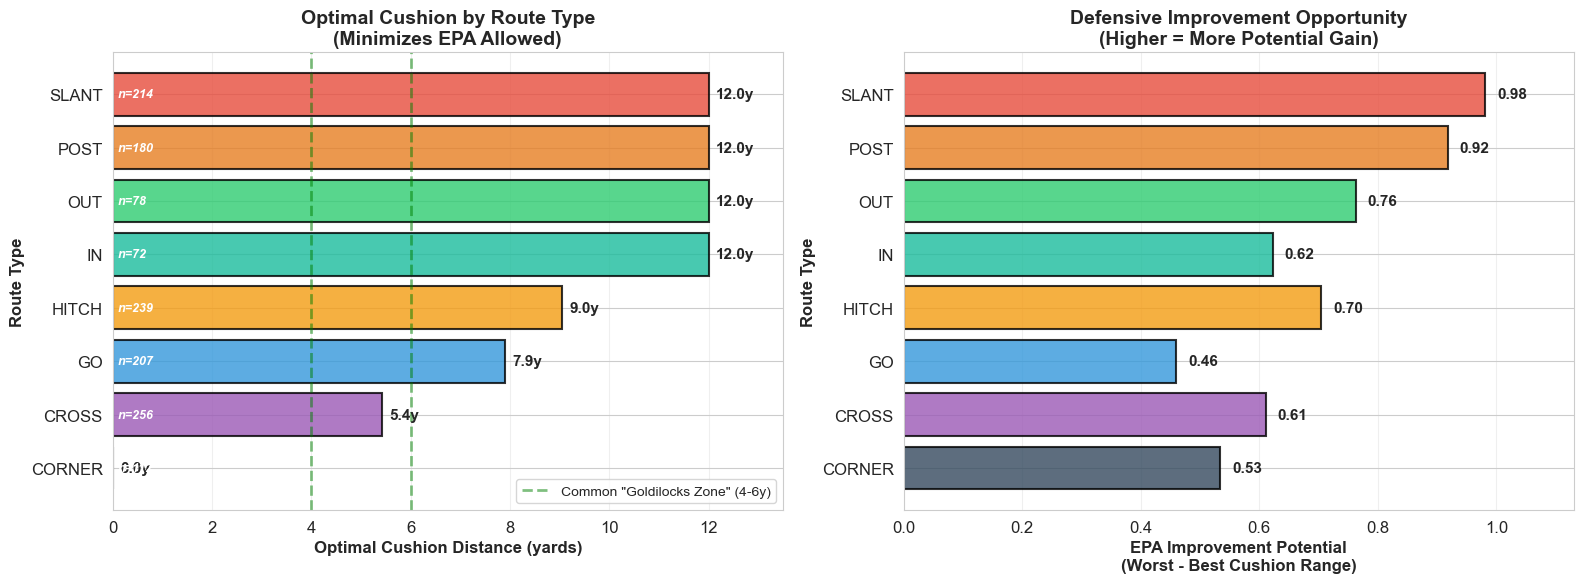

In [3]:
"""
Per-Route Cushion Analysis
Creates individual detailed plots for each route type
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for publication-quality figures
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

# Load data
df = pd.read_csv('../data/processed/cushion_analysis_data.csv')

# Define routes to analyze
major_routes = ['SLANT', 'GO', 'OUT', 'HITCH', 'CROSS', 'IN', 'POST', 'CORNER']

# Color scheme for routes (you can customize)
route_colors = {
    'SLANT': '#e74c3c',    # Red
    'GO': '#3498db',       # Blue
    'OUT': '#2ecc71',      # Green
    'HITCH': '#f39c12',    # Orange
    'CROSS': '#9b59b6',    # Purple
    'IN': '#1abc9c',       # Teal
    'POST': '#e67e22',     # Dark orange
    'CORNER': '#34495e'    # Dark gray
}

def create_route_analysis(route_name, df, save_individual=True):
    """
    Create comprehensive analysis plot for a single route
    
    Parameters:
    - route_name: Name of the route to analyze
    - df: DataFrame with cushion analysis data
    - save_individual: Whether to save as individual file
    """
    
    # Filter to this route
    route_df = df[df['route'] == route_name].copy()
    
    if len(route_df) < 20:
        print(f"Skipping {route_name}: insufficient data (n={len(route_df)})")
        return None
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Main scatter plot (top left, large)
    ax_main = fig.add_subplot(gs[0:2, 0:2])
    
    # Scatter plot with color gradient based on yards gained
    scatter = ax_main.scatter(
        route_df['cushion'], 
        route_df['epa'],
        c=route_df['yards_gained'],
        cmap='RdYlGn_r',
        s=80,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax_main)
    cbar.set_label('Yards Gained', fontsize=11)
    
    # Fit quadratic trend line
    z = np.polyfit(route_df['cushion'], route_df['epa'], 2)
    p = np.poly1d(z)
    x_line = np.linspace(route_df['cushion'].min(), route_df['cushion'].max(), 200)
    y_line = p(x_line)
    
    ax_main.plot(x_line, y_line, 'r-', linewidth=3, alpha=0.8, label='Quadratic Fit')
    
    # Find and mark optimal cushion
    optimal_cushion = x_line[np.argmin(y_line)]
    min_epa = np.min(y_line)
    
    ax_main.axvline(optimal_cushion, color='green', linestyle='--', 
                    linewidth=2.5, alpha=0.8, label=f'Optimal: {optimal_cushion:.1f}y')
    ax_main.plot(optimal_cushion, min_epa, 'g*', markersize=20, 
                markeredgecolor='darkgreen', markeredgewidth=2)
    
    # Calculate correlation
    corr, p_value = stats.pearsonr(route_df['cushion'], route_df['epa'])
    
    # Labels and title
    ax_main.set_xlabel('Cushion Distance (yards)', fontsize=13, weight='bold')
    ax_main.set_ylabel('EPA Allowed', fontsize=13, weight='bold')
    ax_main.set_title(f'{route_name} Route: Cushion vs EPA\n' + 
                      f'n={len(route_df)} plays | r={corr:.3f} (p={p_value:.4f})',
                      fontsize=15, weight='bold', pad=15)
    ax_main.legend(fontsize=11, loc='upper right')
    ax_main.grid(True, alpha=0.3)
    
    # Add mean EPA line
    mean_epa = route_df['epa'].mean()
    ax_main.axhline(mean_epa, color='blue', linestyle=':', 
                    linewidth=2, alpha=0.6, label=f'Mean EPA: {mean_epa:.2f}')
    
    # ============================================
    # Distribution of cushion (top right)
    # ============================================
    ax_dist = fig.add_subplot(gs[0, 2])
    
    ax_dist.hist(route_df['cushion'], bins=15, 
                 color=route_colors.get(route_name, 'steelblue'),
                 alpha=0.7, edgecolor='black')
    ax_dist.axvline(route_df['cushion'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {route_df["cushion"].mean():.1f}y')
    ax_dist.axvline(route_df['cushion'].median(), color='orange', 
                   linestyle='--', linewidth=2, label=f'Median: {route_df["cushion"].median():.1f}y')
    
    ax_dist.set_xlabel('Cushion (yards)', fontsize=11)
    ax_dist.set_ylabel('Frequency', fontsize=11)
    ax_dist.set_title('Cushion Distribution', fontsize=12, weight='bold')
    ax_dist.legend(fontsize=9)
    ax_dist.grid(True, alpha=0.3, axis='y')
    
    # ============================================
    # Box plot by cushion range (middle right)
    # ============================================
    ax_box = fig.add_subplot(gs[1, 2])
    
    # Create cushion categories
    route_df['cushion_cat'] = pd.cut(
        route_df['cushion'],
        bins=[0, 2, 4, 6, 100],
        labels=['0-2y', '2-4y', '4-6y', '6+y']
    )
    
    # Create box plot
    cushion_order = ['0-2y', '2-4y', '4-6y', '6+y']
    bp = ax_box.boxplot(
        [route_df[route_df['cushion_cat'] == cat]['epa'].dropna() 
         for cat in cushion_order if cat in route_df['cushion_cat'].values],
        labels=[cat for cat in cushion_order if cat in route_df['cushion_cat'].values],
        patch_artist=True,
        showmeans=True
    )
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax_box.set_xlabel('Cushion Range', fontsize=11)
    ax_box.set_ylabel('EPA', fontsize=11)
    ax_box.set_title('EPA by Cushion Range', fontsize=12, weight='bold')
    ax_box.grid(True, alpha=0.3, axis='y')
    ax_box.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    
    # ============================================
    # Summary statistics table (bottom)
    # ============================================
    ax_table = fig.add_subplot(gs[2, :])
    ax_table.axis('off')
    
    # Calculate summary stats by cushion range
    summary_data = []
    for cat in cushion_order:
        cat_df = route_df[route_df['cushion_cat'] == cat]
        if len(cat_df) > 0:
            summary_data.append([
                cat,
                len(cat_df),
                f"{cat_df['epa'].mean():.2f}",
                f"{cat_df['epa'].median():.2f}",
                f"{cat_df['yards_gained'].mean():.1f}",
                f"{(cat_df['yards_gained'] > 15).sum() / len(cat_df) * 100:.1f}%"
            ])
    
    # Create table
    table = ax_table.table(
        cellText=summary_data,
        colLabels=['Cushion\nRange', 'Plays', 'Mean\nEPA', 'Median\nEPA', 
                   'Avg Yards\nGained', 'Big Play\nRate (15+y)'],
        cellLoc='center',
        loc='center',
        bbox=[0.1, 0.2, 0.8, 0.6]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    # Style the header
    for i in range(6):
        cell = table[(0, i)]
        cell.set_facecolor('#3498db')
        cell.set_text_props(weight='bold', color='white')
    
    # Highlight best/worst rows
    if summary_data:
        epa_values = [float(row[2]) for row in summary_data]
        best_idx = epa_values.index(min(epa_values))
        worst_idx = epa_values.index(max(epa_values))
        
        for i in range(6):
            table[(best_idx + 1, i)].set_facecolor('#d5f4e6')  # Light green
            table[(worst_idx + 1, i)].set_facecolor('#fadbd8')  # Light red
    
    ax_table.text(0.5, 0.9, 'Summary Statistics by Cushion Range', 
                  ha='center', fontsize=13, weight='bold', transform=ax_table.transAxes)
    ax_table.text(0.5, 0.05, 
                  f'✓ Green = Best Performance  |  ✗ Red = Worst Performance  |  '
                  f'Optimal Cushion: {optimal_cushion:.1f} yards',
                  ha='center', fontsize=11, style='italic', transform=ax_table.transAxes)
    
    # Overall figure title
    fig.suptitle(f'Comprehensive Cushion Analysis: {route_name} Route',
                 fontsize=17, weight='bold', y=0.98)
    
    # Save individual file
    if save_individual:
        filename = f'route_analysis_{route_name.lower()}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Saved: {filename}")
    
    return fig

# ============================================
# Generate analysis for all routes
# ============================================

print("="*60)
print("GENERATING INDIVIDUAL ROUTE ANALYSES")
print("="*60)

for route in major_routes:
    print(f"\nProcessing {route}...")
    fig = create_route_analysis(route, df, save_individual=True)
    if fig:
        plt.close(fig)

print("\n" + "="*60)
print("CREATING COMPARISON SUMMARY")
print("="*60)

# ============================================
# Create summary comparison chart
# ============================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Optimal cushion by route
optimal_cushions = []
sample_sizes = []
epa_improvements = []

for route in major_routes:
    route_df = df[df['route'] == route]
    
    if len(route_df) < 20:
        continue
    
    # Fit quadratic
    z = np.polyfit(route_df['cushion'], route_df['epa'], 2)
    p = np.poly1d(z)
    x_line = np.linspace(0, 12, 200)
    
    optimal = x_line[np.argmin(p(x_line))]
    
    # Calculate EPA improvement (worst - best)
    route_df_copy = route_df.copy()
    route_df_copy['cushion_group'] = pd.cut(
        route_df_copy['cushion'],
        bins=[0, 2, 4, 6, 100],
        labels=['0-2y', '2-4y', '4-6y', '6+y']
    )
    
    epa_by_group = route_df_copy.groupby('cushion_group', observed=True)['epa'].mean()
    if len(epa_by_group) > 0:
        improvement = epa_by_group.max() - epa_by_group.min()
    else:
        improvement = 0
    
    optimal_cushions.append(optimal)
    sample_sizes.append(len(route_df))
    epa_improvements.append(improvement)

# Sort by optimal cushion
routes_sorted = [r for r, _ in sorted(zip([r for r in major_routes if len(df[df['route'] == r]) >= 20], 
                                          optimal_cushions))]
cushions_sorted = sorted(optimal_cushions)
sizes_sorted = [s for _, s in sorted(zip(optimal_cushions, sample_sizes))]

# Plot 1: Optimal cushions
bars = ax1.barh(routes_sorted, cushions_sorted, 
                color=[route_colors.get(r, 'steelblue') for r in routes_sorted],
                alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels and sample sizes
for i, (route, cushion, size) in enumerate(zip(routes_sorted, cushions_sorted, sizes_sorted)):
    ax1.text(cushion + 0.15, i, f'{cushion:.1f}y', 
            va='center', fontsize=11, weight='bold')
    ax1.text(0.1, i, f'n={size}', 
            va='center', fontsize=9, style='italic', color='white', weight='bold')

ax1.set_xlabel('Optimal Cushion Distance (yards)', fontsize=12, weight='bold')
ax1.set_ylabel('Route Type', fontsize=12, weight='bold')
ax1.set_title('Optimal Cushion by Route Type\n(Minimizes EPA Allowed)', 
             fontsize=14, weight='bold')
ax1.set_xlim(0, max(cushions_sorted) + 1.5)
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(4, color='green', linestyle='--', linewidth=2, alpha=0.5, 
           label='Common "Goldilocks Zone" (4-6y)')
ax1.axvline(6, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax1.legend(fontsize=10)

# Plot 2: EPA improvement potential
improvements_sorted = [imp for _, imp in sorted(zip(optimal_cushions, epa_improvements))]

bars2 = ax2.barh(routes_sorted, improvements_sorted,
                 color=[route_colors.get(r, 'steelblue') for r in routes_sorted],
                 alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (route, imp) in enumerate(zip(routes_sorted, improvements_sorted)):
    ax2.text(imp + 0.02, i, f'{imp:.2f}', 
            va='center', fontsize=11, weight='bold')

ax2.set_xlabel('EPA Improvement Potential\n(Worst - Best Cushion Range)', 
              fontsize=12, weight='bold')
ax2.set_ylabel('Route Type', fontsize=12, weight='bold')
ax2.set_title('Defensive Improvement Opportunity\n(Higher = More Potential Gain)', 
             fontsize=14, weight='bold')
ax2.set_xlim(0, max(improvements_sorted) + 0.15)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('route_comparison_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: route_comparison_summary.png")

print("\n" + "="*60)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*60)
print(f"\nGenerated {len(major_routes)} individual route analyses")
print("Plus 1 comprehensive comparison summary")
print("\nFiles saved in current directory")

In [7]:
def find_optimal_cushion_robust(route_name, df):
    """
    Find optimal cushion using binned approach (no polynomial fitting)
    """
    route_df = df[df['route'] == route_name].copy()
    
    if len(route_df) < 50:
        return None
    
    # Create bins
    route_df['cushion_bin'] = pd.cut(
        route_df['cushion'],
        bins=[0, 2, 4, 6, 8, 100],
        labels=['0-2y', '2-4y', '4-6y', '6-8y', '8+y']
    )
    
    # Calculate EPA by bin
    bin_summary = route_df.groupby('cushion_bin', observed=True).agg({
        'epa': ['count', 'mean', 'std']
    }).round(3)
    
    # Only trust bins with decent sample size
    bin_summary_filtered = bin_summary[bin_summary[('epa', 'count')] >= 15]
    
    if len(bin_summary_filtered) == 0:
        return None
    
    # Find best bin
    best_bin = bin_summary_filtered[('epa', 'mean')].idxmin()
    best_epa = bin_summary_filtered[('epa', 'mean')].min()
    
    # Return midpoint of best bin
    bin_midpoints = {
        '0-2y': 1.0,
        '2-4y': 3.0,
        '4-6y': 5.0,
        '6-8y': 7.0,
        '8+y': 9.0
    }
    
    return {
        'route': route_name,
        'optimal_bin': best_bin,
        'optimal_cushion': bin_midpoints[best_bin],
        'best_epa': best_epa,
        'sample_summary': bin_summary
    }

# Test it
result = find_optimal_cushion_robust('SLANT', df)
print(result)

for route in ['HITCH', 'OUT', 'CROSS', 'IN', 'GO']:
    result = find_optimal_cushion_robust(route, df)
    if result:
        print(f"\n{route}:")
        print(result['sample_summary'])
        print(f"Optimal bin: {result['optimal_bin']} (EPA: {result['best_epa']:.3f})")


{'route': 'SLANT', 'optimal_bin': '0-2y', 'optimal_cushion': 1.0, 'best_epa': 0.862, 'sample_summary':               epa              
            count   mean    std
cushion_bin                    
0-2y          107  0.862  1.381
2-4y           51  1.309  1.251
4-6y           41  1.075  0.908
6-8y           12  0.816  1.726
8+y             3  0.167  1.217}

HITCH:
              epa              
            count   mean    std
cushion_bin                    
0-2y           67  0.879  1.019
2-4y           80  1.235  1.618
4-6y           68  0.530  1.410
6-8y           16  0.816  0.657
8+y             8  0.755  0.984
Optimal bin: 4-6y (EPA: 0.530)

OUT:
              epa              
            count   mean    std
cushion_bin                    
0-2y           69  1.524  0.951
2-4y           86  1.175  1.278
4-6y           53  0.913  1.027
6-8y           27  1.497  1.013
8+y            21  1.171  1.513
Optimal bin: 4-6y (EPA: 0.913)

CROSS:
              epa              
            

In [9]:
from scipy import stats
import numpy as np

def test_cushion_difference(route_name, df, bin1, bin2):
    """
    Test if two cushion bins have significantly different EPA
    
    Parameters:
    - route_name: e.g., 'HITCH'
    - bin1, bin2: e.g., '4-6y', '2-4y'
    """
    route_df = df[df['route'] == route_name].copy()
    
    # Create bins with proper labels
    route_df['cushion_bin'] = pd.cut(
        route_df['cushion'],
        bins=[0, 2, 4, 6, 8, 100],
        labels=['0-2y', '2-4y', '4-6y', '6-8y', '8+y']
    )
    
    # Get data for each bin
    group1 = route_df[route_df['cushion_bin'] == bin1]['epa'].dropna()
    group2 = route_df[route_df['cushion_bin'] == bin2]['epa'].dropna()
    
    # Check sample sizes
    if len(group1) < 2 or len(group2) < 2:
        print(f"\nInsufficient data: {bin1} n={len(group1)}, {bin2} n={len(group2)}")
        return None
    
    # Calculate statistics
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    
    # T-test
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    # Cohen's d (effect size)
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Print results
    print(f"\n{route_name}: {bin1} vs {bin2}")
    print(f"  {bin1}: n={len(group1):3d}, mean={mean1:.3f}, std={std1:.3f}")
    print(f"  {bin2}: n={len(group2):3d}, mean={mean2:.3f}, std={std2:.3f}")
    print(f"  Difference: {abs(mean1 - mean2):.3f} EPA")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else '(not sig)'}")
    print(f"  Cohen's d: {abs(cohens_d):.3f} ({interpret_cohens_d(abs(cohens_d))})")
    
    return {
        'route': route_name,
        'bin1': bin1,
        'bin2': bin2,
        'mean_diff': abs(mean1 - mean2),
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }

def interpret_cohens_d(d):
    """Interpret Cohen's d effect size"""
    if d < 0.2:
        return "negligible"
    elif d < 0.5:
        return "small"
    elif d < 0.8:
        return "medium"
    else:
        return "large"

# Run tests for your key findings
print("="*60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

# Test 1: HITCH optimal vs worst
test_cushion_difference('HITCH', df, '4-6y', '2-4y')

# Test 2: OUT optimal vs worst
test_cushion_difference('OUT', df, '4-6y', '0-2y')

# Test 3: SLANT optimal vs worst
test_cushion_difference('SLANT', df, '0-2y', '2-4y')

# Test 4: CROSS optimal vs worst
test_cushion_difference('CROSS', df, '4-6y', '0-2y')

# Test 5: IN - should show no difference
test_cushion_difference('IN', df, '0-2y', '2-4y')

# Test 6: GO - should show no clear pattern
test_cushion_difference('GO', df, '0-2y', '2-4y')

STATISTICAL SIGNIFICANCE TESTS

HITCH: 4-6y vs 2-4y
  4-6y: n= 68, mean=0.530, std=1.410
  2-4y: n= 80, mean=1.235, std=1.618
  Difference: 0.705 EPA
  t-statistic: -2.801
  p-value: 0.0058 **
  Cohen's d: 0.465 (small)

OUT: 4-6y vs 0-2y
  4-6y: n= 53, mean=0.913, std=1.027
  0-2y: n= 69, mean=1.524, std=0.951
  Difference: 0.611 EPA
  t-statistic: -3.398
  p-value: 0.0009 ***
  Cohen's d: 0.617 (medium)

SLANT: 0-2y vs 2-4y
  0-2y: n=107, mean=0.862, std=1.381
  2-4y: n= 51, mean=1.309, std=1.251
  Difference: 0.447 EPA
  t-statistic: -1.960
  p-value: 0.0518 (not sig)
  Cohen's d: 0.339 (small)

CROSS: 4-6y vs 0-2y
  4-6y: n= 35, mean=1.169, std=1.432
  0-2y: n= 52, mean=1.629, std=1.488
  Difference: 0.460 EPA
  t-statistic: -1.435
  p-value: 0.1549 (not sig)
  Cohen's d: 0.315 (small)

IN: 0-2y vs 2-4y
  0-2y: n= 37, mean=1.268, std=1.067
  2-4y: n= 42, mean=1.230, std=1.396
  Difference: 0.038 EPA
  t-statistic: 0.135
  p-value: 0.8926 (not sig)
  Cohen's d: 0.031 (negligible)

G

{'route': 'GO',
 'bin1': '0-2y',
 'bin2': '2-4y',
 'mean_diff': 0.016477941159963816,
 'p_value': 0.9459921543114984,
 'cohens_d': 0.01328669249966226,
 'significant': False}